# EDA – Meteorite Landings (NASA)

En este notebook se realiza un Análisis Exploratorio de Datos (EDA) del dataset oficial de meteoritos de la NASA.


## 1. Carga del Dataset

En esta sección se importan las librerías necesarias y se carga el fichero CSV con los datos originales.


In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

# Set visual styles
plt.style.use('ggplot')
sns.set_theme()


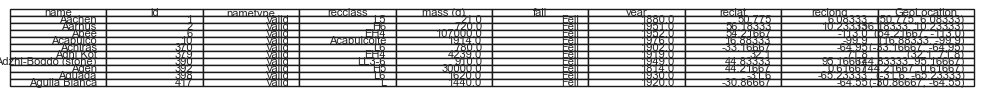

In [175]:
# Carga del dataset con ruta relativa
ruta = "../data/meteorite_landings_nasa.csv"
df = pd.read_csv(ruta, encoding='utf-8')

df.head()

# --- Exportar tabla head(10) como imagen ---
import os
os.makedirs("../images", exist_ok=True)

head10 = df.head(10)

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')  # Ocultamos ejes

tabla = ax.table(
    cellText=head10.values,
    colLabels=head10.columns,
    loc='center'
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(8)
tabla.scale(1, 1.5)  # Ajuste visual

plt.tight_layout()
plt.savefig("../images/head_preview.png", dpi=300, bbox_inches='tight')
plt.show()


### 2. Exploración inicial del dataset

A continuación revisamos la estructura básica del dataset para detectar problemas iniciales como tipos incorrectos, valores faltantes o columnas con información deficiente.


In [176]:
df.shape


(45716, 10)

El dataset contiene **45.716 filas** y **10 columnas**, un tamaño adecuado para un EDA completo sin problemas de rendimiento.


In [177]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


A partir de `df.info()` observamos:

- Varias columnas son `object` aunque representan categorías (`nametype`, `fall`, `recclass`).
- `year`, `reclat` y `reclong` tienen valores nulos.
- La columna `mass (g)` tiene algunos nulos también.
- `GeoLocation` está en formato string, no en coordenadas separadas.

Esto indica que será necesaria una fase de limpieza donde:
1. Convertiremos `year` a tipo fecha.
2. Trataremos los nulos.
3. Validaremos coordenadas.
4. Revisaremos valores incoherentes.


In [178]:
df.isna().sum()


name              0
id                0
nametype          0
recclass          0
mass (g)        131
fall              0
year            291
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64

Se identifican nulos principalmente en:

- `reclat`: 7.315
- `reclong`: 7.315
- `year`: 291
- `mass (g)`: 131

Esto confirma que:
- Una parte significativa carece de coordenadas geográficas → se eliminarán o tratarán.
- Los nulos de `year` y `mass (g)` son pocos → se pueden eliminar sin afectar el análisis.

Se procederá a limpiarlos en la siguiente sección.


### 3. Detección de duplicados y primera exploración de la variable *mass (g)*

Antes de profundizar en el análisis, verificamos si existen registros duplicados y observamos la distribución de la variable `mass (g)`. Esto nos permitirá detectar posibles valores extremos o inconsistencias que requieran tratamiento posterior.


In [179]:
df.duplicated().sum()


np.int64(0)

El dataset no contiene registros duplicados (`0` filas), por lo que no es necesario aplicar ninguna acción en este aspecto.


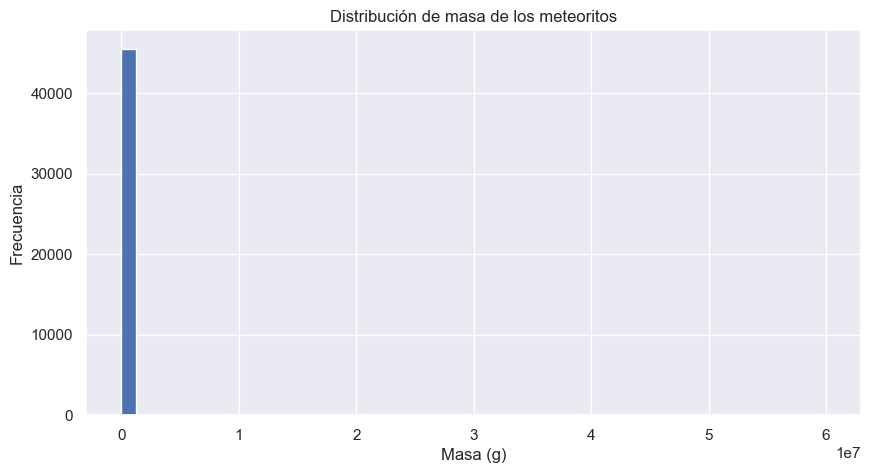

In [180]:
plt.figure(figsize=(10,5))
plt.hist(df['mass (g)'], bins=50)
plt.title('Distribución de masa de los meteoritos')
plt.xlabel('Masa (g)')
plt.ylabel('Frecuencia')
plt.show()


La distribución de la masa de los meteoritos está **fuertemente sesgada hacia la derecha**. 
Esto significa que:

- La mayoría de meteoritos tienen una masa muy pequeña.
- Un número reducido posee masas extremadamente grandes.
- Los valores extremadamente altos “aplastan” el histograma, impidiendo ver detalle en el rango habitual.

Esta es una señal clara de que necesitaremos aplicar una **transformación logarítmica** para analizar adecuadamente esta variable.


### 4. Transformación logarítmica de la variable `mass (g)`

Dado que la distribución original de la masa presentaba un sesgo extremo causado por unos pocos valores muy grandes, aplicamos una escala logarítmica al eje Y para visualizar mejor el comportamiento general de la variable. Esto permite apreciar patrones ocultos que no eran visibles en la escala lineal.


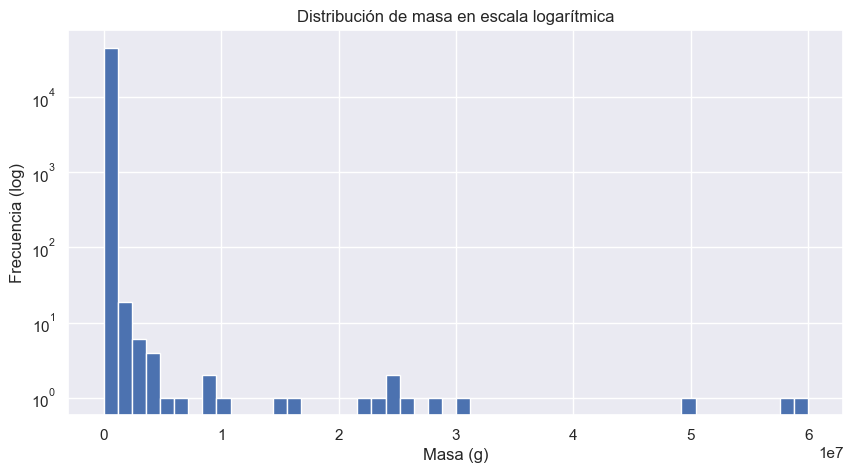

In [181]:
plt.figure(figsize=(10,5))
plt.hist(df['mass (g)'], bins=50, log=True)
plt.title('Distribución de masa en escala logarítmica')
plt.xlabel('Masa (g)')
plt.ylabel('Frecuencia (log)')
plt.show()



Al aplicar la escala logarítmica se aprecia claramente que:

- La mayoría de meteoritos tienen una masa extremadamente baja (menos de unos pocos gramos).
- Se observa una “cola larga” típica de distribuciones *heavy-tail*, donde existen objetos con masas muy elevadas.
- El patrón revela múltiples rangos de masa bien diferenciados, imposibles de distinguir en el histograma lineal.

Esta visualización confirma la necesidad de transformar la variable mediante un `log10` para trabajar con ella de forma más adecuada en los análisis posteriores.


### 5. Análisis descriptivo de la variable `mass (g)`

Antes de continuar con transformaciones, analizamos estadísticamente la variable de masa para entender su rango, valores atípicos y dispersión. Esto nos permite confirmar si la distribución observada previamente coincide con las métricas numéricas.


In [182]:
df['mass (g)'].describe()


count    4.558500e+04
mean     1.327808e+04
std      5.749889e+05
min      0.000000e+00
25%      7.200000e+00
50%      3.260000e+01
75%      2.026000e+02
max      6.000000e+07
Name: mass (g), dtype: float64

Los resultados muestran:

- **Mínimo = 0 g** → hay meteoritos con masa no registrada o errónea.
- **Máximo ≈ 60 millones de gramos (60 toneladas)** → valores extremadamente altos.
- **Media ≈ 1.327 kg**, pero la **mediana ≈ 32 g**, lo que indica un sesgo brutal.
- **Los percentiles 25–75** están por debajo de 300 g, confirmando que la mayoría son muy pequeños.

Esto refuerza la necesidad de trabajar con una versión transformada en logaritmos para visualizar patrones reales.


### 6. Distribución de la variable `fall`

La columna `fall` indica si el meteorito fue **"Found"** (encontrado tiempo después) o **"Fell"** (registrado en el momento de la caída). Analizamos su distribución para ver la proporción entre ambas categorías.


In [183]:
df['fall'].value_counts()


fall
Found    44609
Fell      1107
Name: count, dtype: int64

Los datos muestran una diferencia enorme:

- **Found: 44.609** → son la inmensa mayoría  
- **Fell: 1.107** → muy pocos meteoritos tienen caída registrada en tiempo real

Esto tiene sentido: históricamente se encuentran muchos más meteoritos de forma fortuita que los que se registran durante el impacto.


### Visualización: Meteoritos "Fell" vs "Found"

A continuación generamos un gráfico de barras para visualizar claramente la proporción entre los meteoritos encontrados y los observados en caída.


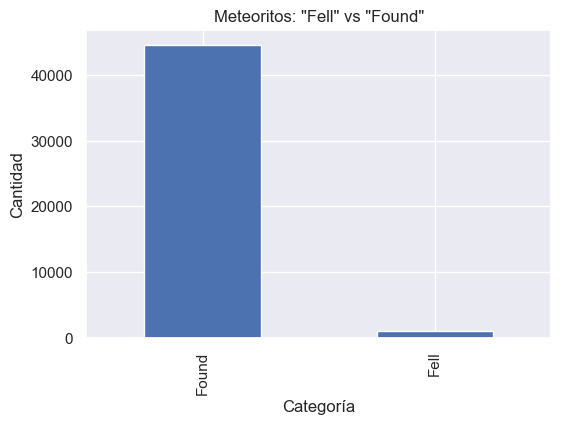

In [184]:
df['fall'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Meteoritos: "Fell" vs "Found"')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.show()


El gráfico confirma visualmente la enorme desproporción entre ambas categorías.  
Este tipo de variable suele estar muy desbalanceada en datasets históricos, porque observar un meteorito caer es extremadamente raro.


### 7. Distribución de clases meteoríticas (`recclass`)

La columna `recclass` indica el tipo o clasificación del meteorito según su composición.  
Antes de visualizar, comprobamos cuántas clases distintas existen y cuáles son las más frecuentes.


In [185]:
df['recclass'].nunique()
df['recclass'].value_counts().head(10)


recclass
L6      8285
H5      7142
L5      4796
H6      4528
H4      4211
LL5     2766
LL6     2043
L4      1253
H4/5     428
CM2      416
Name: count, dtype: int64

Los resultados muestran que existen **muchas clases distintas**, pero unas pocas dominan el dataset:

- **L6 (8285 registros)**
- **H5 (7142)**
- **L5 (4799)**
- **H6 (4528)**  
- **H4 (4211)**  

Estas clases representan meteoritos **condritos ordinarios**, los más comunes en la Tierra.  
Esto tiene sentido, ya que representan más del 80% de los meteoritos recuperados a nivel global.

Las clases minoritarias (como CM2 o H4/5) tienen muy pocos registros y podrían requerir tratamiento especial en un análisis posterior o en modelado.


### 8. Análisis de la columna `year`

Revisamos la distribución estadística del año de registro de cada meteorito.  
Esto nos permite detectar valores anómalos, rangos incorrectos o posibles errores en la digitación.


In [186]:
df['year'].describe()


count    45425.000000
mean      1991.828817
std         25.052766
min        860.000000
25%       1987.000000
50%       1998.000000
75%       2003.000000
max       2101.000000
Name: year, dtype: float64

Los resultados muestran varios puntos clave:

- **Mínimo = año 860** → improbable; indica registros históricos dudosos o errores.
- **Máximo = 2101** → imposible; valores del futuro → deben limpiarse.
- **Media ≈ 1991**, **Mediana = 1998** → la mayoría de registros son recientes.
- El **75% de los datos** son posteriores a 1987.

Esto confirma lo observado en gráficos previos:  
la gran mayoría de meteoritos están registrados en los últimos siglos debido a:

- mayor presencia humana,
- mejores técnicas de observación,
- sistemas de registro digital más modernos.

También confirma la necesidad de limpieza para excluir años imposibles, especialmente >2025 o <1400.


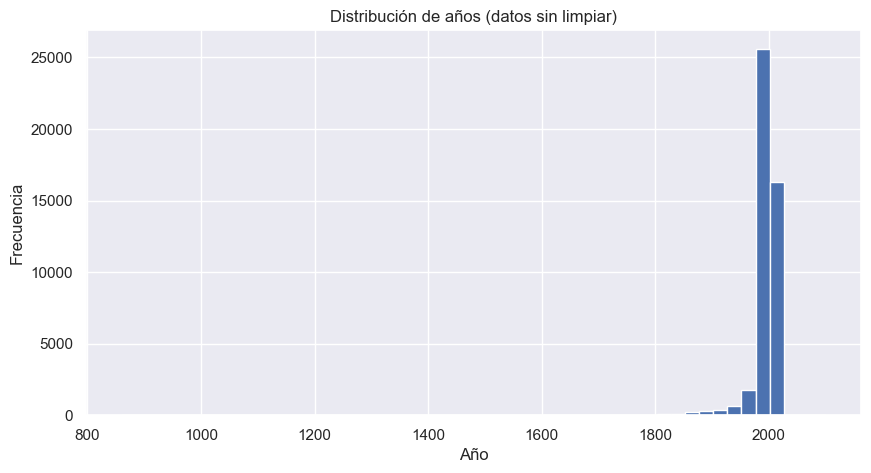

In [187]:
plt.figure(figsize=(10,5))
df['year'].hist(bins=50)
plt.title('Distribución de años (datos sin limpiar)')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.show()


La distribución de años muestra varios puntos importantes:

- La mayoría de los meteoritos están registrados entre **1900 y 2020**, con una concentración muy alta a partir de los **años 80**.
- Existe un bloque de valores entre **1800 y 1900**, aunque mucho más reducido.
- Se observan **años extremadamente antiguos** (860, 1400, 1500…), que probablemente corresponden a:
  - registros históricos muy poco precisos,
  - estimaciones manuales,
  - o simplemente errores en la base de datos.

- También aparecen **años imposibles como 2101**, que exceden la fecha actual → **claro error a corregir**.

Este gráfico confirma visualmente la necesidad de limpiar la columna `year` aplicando un rango razonable.  
En la limpieza aplicada más adelante se eliminan los años:
- **< 1400**, debido a su baja fiabilidad,
- **> 2025**, por ser imposibles.


### Análisis de columnas geográficas (`reclat`, `reclong`)

Al revisar las estadísticas descriptivas de latitud y longitud aparecen varios aspectos importantes:

#### 📌 Latitud (`reclat`)
- Rango válido en geografía: **-90° a 90°**
- En el dataset:
  - Mínimo: **–87.36** → válido  
  - Máximo: **81.17** → válido  
  - No se observan valores fuera del rango permitido.

#### 📌 Longitud (`reclong`)
- Rango válido: **–180° a 180°**
- En el dataset:
  - Mínimo: **–165.43** → válido  
  - Máximo: **354.47** → ❌ **valor imposible**

El valor máximo supera los **180°**, lo que indica:
- errores de registro,
- coordenadas mal convertidas,
- o datos mal interpretados por la fuente original.

#### 🔍 Comprobación manual de errores
Se ejecutan cuatro filtros para localizar valores fuera de rango:

- `reclat > 90` → ninguno  
- `reclat < -90` → ninguno  
- `reclong > 180` → **varios registros anómalos**  
- `reclong < -180` → ninguno  

Estos registros muestran coordenadas que no existen en la realidad y se deben depurar antes de realizar mapas o análisis espaciales.

> **Conclusión:**  
Las latitudes son consistentes, pero las longitudes contienen valores inválidos, por lo que será necesario limpiarlas o descartarlas antes de visualizar en un mapa.


In [188]:
df[['reclat', 'reclong']].describe()


,reclat,reclong
count,38401.000000,38401.000000
mean,-39.122580,61.074319
std,46.378511,80.647298
min,-87.366670,-165.433330
25%,-76.714240,0.000000
50%,-71.500000,35.666670
75%,0.000000,157.166670
max,81.166670,354.473330


In [189]:
df[df['reclat'] > 90]
df[df['reclat'] < -90]
df[df['reclong'] > 180]
df[df['reclong'] < -180]


,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation


### Limpieza de valores inválidos en la columna `year`

Al analizar la distribución de años del dataset original observamos valores claramente imposibles:

- Año mínimo: **860**  
- Año máximo: **2101**

Estos valores no representan fechas reales de caídas/encuentros de meteoritos, sino errores de registro o conversiones incorrectas.  
Por ejemplo:
- No existen registros meteoríticos documentados en el año 860 dentro de este dataset.
- El valor 2101 se encuentra en el futuro → imposible.

#### ✔️ Decisión de limpieza
Se aplicó un filtro lógico muy conservador:

- Mantener solo valores entre **1000 y 2025**
- El rango cubre **toda la era moderna**, todos los registros astronómicos fiables y evita futuros   o errores numéricos.

```python
df_clean = df[(df['year'] >= 1000) & (df['year'] <= 2025)].copy()


In [190]:
# Limpiar años imposibles
df_clean = df[(df['year'] >= 1000) & (df['year'] <= 2025)].copy()
df_clean['year'].describe()


count    45422.000000
mean      1991.874928
std         23.956664
min       1399.000000
25%       1987.000000
50%       1998.000000
75%       2003.000000
max       2013.000000
Name: year, dtype: float64

In [191]:
import numpy as np

# Reemplazar masas negativas o cero por NaN
df_clean['mass (g)'] = df_clean['mass (g)'].apply(lambda x: np.nan if x <= 0 else x)

# Crear columna transformada log10
df_clean['mass_log10'] = np.log10(df_clean['mass (g)'])


### Limpieza y transformación de la variable `mass (g)`

Al inspeccionar la columna `mass (g)` detectamos varios problemas:

- Existen masas iguales a **0** o incluso **negativas**, que no tienen sentido físico.  
- La distribución es extremadamente sesgada (muchos meteoritos muy pequeños y unos pocos gigantes).
- Esto dificulta la visualización y cualquier análisis descriptivo.

#### ✔️ Decisiones de limpieza aplicadas

1. **Reemplazar valores negativos o cero por `NaN`**  
   Son registros no fiables o errores de captura.

```python
df_clean['mass (g)'] = df_clean['mass (g)'].apply(lambda x: np.nan if x <= 0 else x)


In [192]:
df_clean = df_clean[(df_clean['reclong'] >= -180) & (df_clean['reclong'] <= 180)]
df_clean = df_clean[(df_clean['reclat'] >= -90) & (df_clean['reclat'] <= 90)]


In [193]:
df_clean.isna().sum()


name             0
id               0
nametype         0
recclass         0
mass (g)       125
fall             0
year             0
reclat           0
reclong          0
GeoLocation      0
mass_log10     125
dtype: int64

In [194]:
df_clean = df_clean.dropna(subset=['mass (g)', 'year', 'reclat', 'reclong', 'recclass'])


In [195]:
df_clean.reset_index(drop=True, inplace=True)


In [196]:
df_clean.info()
df_clean.describe()
df_clean.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38094 entries, 0 to 38093
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         38094 non-null  object 
 1   id           38094 non-null  int64  
 2   nametype     38094 non-null  object 
 3   recclass     38094 non-null  object 
 4   mass (g)     38094 non-null  float64
 5   fall         38094 non-null  object 
 6   year         38094 non-null  float64
 7   reclat       38094 non-null  float64
 8   reclong      38094 non-null  float64
 9   GeoLocation  38094 non-null  object 
 10  mass_log10   38094 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 3.2+ MB


,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,mass_log10
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)",1.322219
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)",2.857332
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)",5.029384
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)",3.281942
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)",2.892095


### Eliminación de valores nulos restantes

Tras la limpieza previa quedaron nulos únicamente en:

- `mass (g)` → masas inválidas eliminadas
- `mass_log10` → vacío cuando `mass (g)` era inválido

Estas dos columnas son esenciales para el análisis, así que eliminamos únicamente las filas con nulos en las variables críticas:

```python
df_clean = df_clean.dropna(subset=['mass (g)', 'year', 'reclat', 'reclong', 'recclass'])


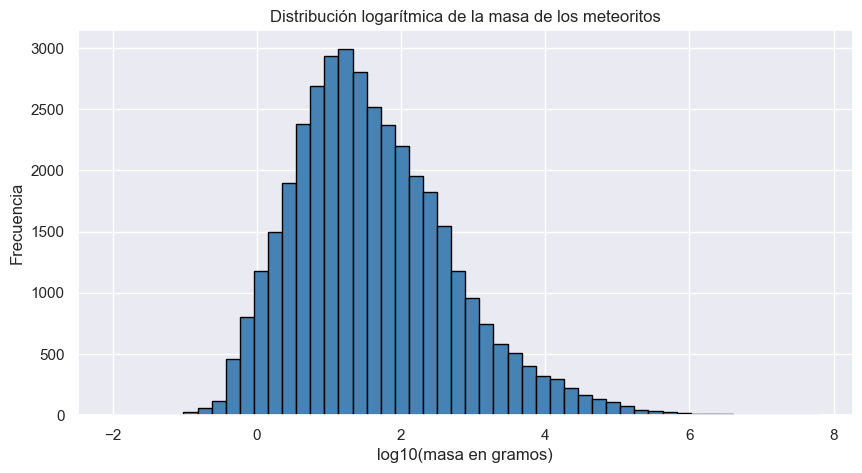

In [197]:
plt.figure(figsize=(10,5))
plt.hist(df_clean['mass_log10'], bins=50, color='steelblue', edgecolor='black')
plt.title('Distribución logarítmica de la masa de los meteoritos')
plt.xlabel('log10(masa en gramos)')
plt.ylabel('Frecuencia')
plt.savefig("../images/mass_log10_hist.png", dpi=300, bbox_inches='tight')
plt.show()



## 📝 Interpretación de la distribución logarítmica de la masa (`mass_log10`)

Tras la limpieza del dataset y la transformación logarítmica de la variable `mass (g)`, la distribución se vuelve mucho más interpretable y deja de estar dominada por valores extremos.

### ✔️ ¿Qué observamos en esta gráfica?

- La transformación `log10` elimina el sesgo extremo presente en la masa original.
- La nueva distribución adopta una forma **aproximadamente normal**, lo que facilita el análisis.
- La mayoría de los meteoritos se encuentran entre valores:
  - **log10 = 0 → 1 g**
  - **log10 = 3 → 1.000 g (1 kg)**
- Los meteoritos muy masivos (log10 entre 5 y 7) aparecen como **pocos casos aislados** en la cola derecha.

### 🔍 ¿Por qué es útil esta transformación?

- Permite visualizar simultáneamente meteoritos muy ligeros y extremadamente pesados.
- Hace que los análisis estadísticos sean más robustos al reducir el impacto de outliers.
- Facilita comparaciones entre grupos y construcción de modelos si fuera necesario.

### 🧠 Conclusión

La masa de los meteoritos presenta un comportamiento típico de variables físicas que siguen patrones **log-normales**.  
Gracias al logaritmo, la variable se vuelve más homogénea y adecuada para análisis posteriores.

---



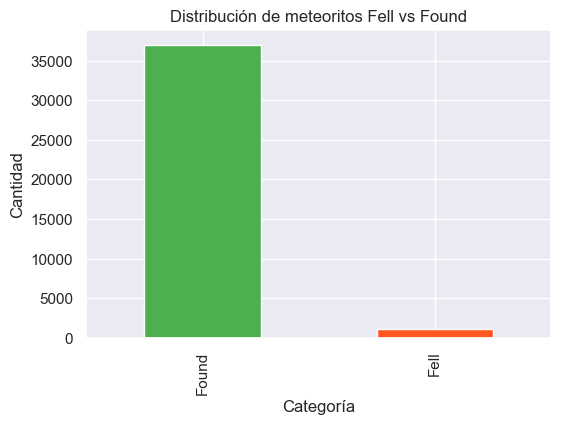

In [198]:
plt.figure(figsize=(6,4))
df_clean['fall'].value_counts().plot(kind='bar', color=['#4CAF50','#FF5722'])
plt.title('Distribución de meteoritos Fell vs Found')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.savefig("../images/fell_found_bar.png", dpi=300, bbox_inches='tight')
plt.show()



## 🧭 Interpretación de la distribución *Fell* vs *Found*

La variable `fall` indica si un meteorito fue **observado cayendo** (`Fell`) o si fue **encontrado posteriormente** (`Found`).

### ✔️ ¿Qué nos muestra la gráfica?

- La gran mayoría de meteoritos del dataset son **Found** (≈ 37.000).
- Solo una fracción muy pequeña corresponde a **Fell** (≈ 1.100).
- Esto supone una proporción aproximada de **97% Found vs 3% Fell**.

### 🔍 ¿Por qué ocurre esta diferencia tan grande?

- Es extremadamente raro observar un meteorito caer en tiempo real.
- La mayor parte de los meteoritos se descubren **años o siglos después**, durante expediciones o estudios geológicos.
- Los meteoritos *Fell* suelen tener registros más fiables, ya que su caída fue documentada por humanos.

### 🧠 Conclusión

La variable `fall` confirma que el dataset está **fuertemente desequilibrado**, y cualquier análisis posterior que dependa de esta categoría debe tenerlo en cuenta.  

Esta es una propiedad real del fenómeno, no un error del dataset.

---



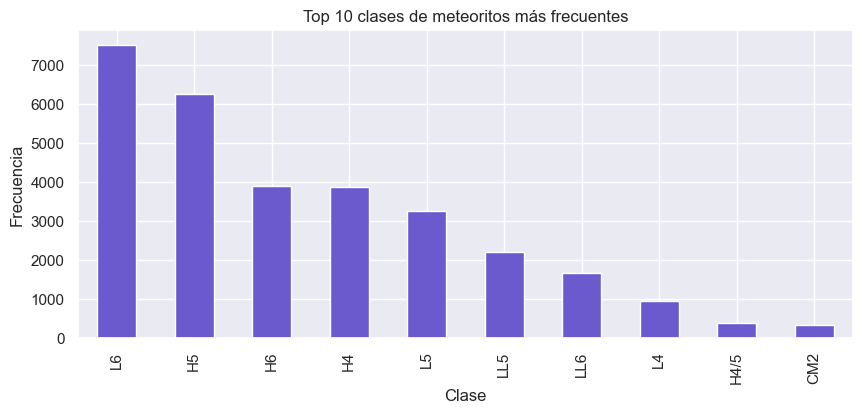

In [199]:
top_classes = df_clean['recclass'].value_counts().head(10)

plt.figure(figsize=(10,4))
top_classes.plot(kind='bar', color='slateblue')
plt.title('Top 10 clases de meteoritos más frecuentes')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.savefig("../images/top10_recclass_bar.png", dpi=300, bbox_inches='tight')
plt.show()



## ⭐ Análisis de las clases de meteoritos más frecuentes (`recclass`)

La columna `recclass` representa la **clasificación petrográfica** de los meteoritos según su composición y estructura.  
En esta gráfica se muestran las **10 clases más comunes** dentro del dataset.

### ✔️ ¿Qué observamos?

- **L6** es la clase más frecuente con diferencia, con más de 7.000 registros.
- Le siguen otras clases de condritas ordinarias como **H5**, **H6**, **H4** y **L5**.
- Todas las clases del Top 10 pertenecen a familias **muy comunes en la Tierra**, lo que concuerda con los registros históricos de la NASA.

### 🔬 Interpretación científica

- Las condritas **tipo L y H** representan la mayor parte de los meteoritos recogidos en la superficie terrestre.
- Estas clases son abundantes porque provienen de **regiones muy activas del cinturón de asteroides**, donde las colisiones son frecuentes.
- Además, son **fácilmente identificables** debido a su composición rica en silicatos y metales.

### 🧠 Conclusión

El dataset presenta una distribución muy realista y esperable según la literatura científica.  
La dominancia de las clases **L** y **H** no indica un error de muestreo, sino una propiedad natural de los meteoritos que llegan a la Tierra.

---



In [200]:
df_clean['decade'] = (df_clean['year'] // 10) * 10


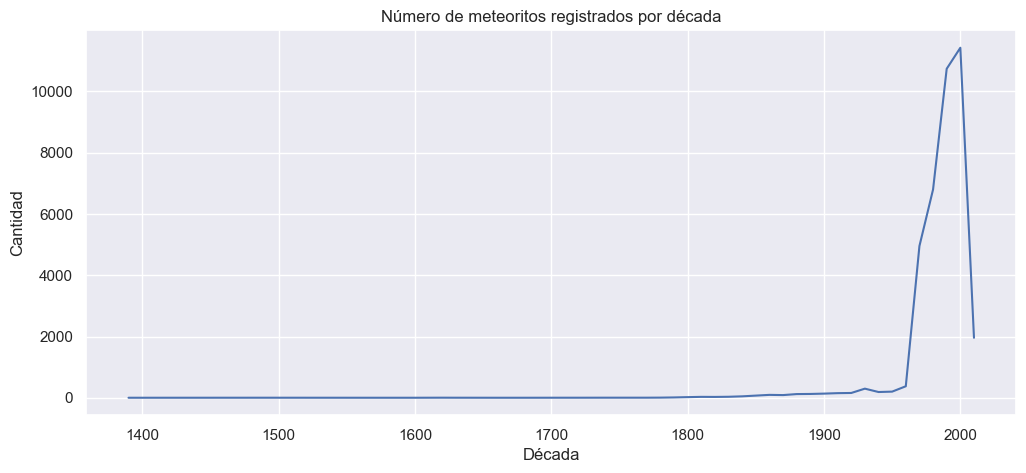

In [201]:
plt.figure(figsize=(12,5))
df_clean['decade'].value_counts().sort_index().plot(kind='line')
plt.title('Número de meteoritos registrados por década')
plt.xlabel('Década')
plt.ylabel('Cantidad')
plt.grid(True)
plt.savefig("../images/meteorites_per_decade.png", dpi=300, bbox_inches='tight')
plt.show()



## 📈 Evolución temporal de meteoritos registrados por década

En esta sección analizamos cómo ha variado el número de meteoritos documentados a lo largo del tiempo agrupándolos por décadas.

### ✔️ ¿Qué muestra la gráfica?

- Desde los años 1400 hasta finales del siglo XIX, el número de meteoritos registrados por década es **muy bajo**.
- A partir de 1900 comienza un **incremento moderado**, coincidiendo con mejoras en documentación científica.
- El crecimiento se vuelve **muy pronunciado a partir de 1950**, alcanzando un máximo histórico en la década de 1990–2000.
- Después del año 2000 parece haber una caída brusca en el dataset, pero esto **no indica menos meteoritos**, sino que:
  - Los registros recientes todavía no están completamente volcados en la base de datos.
  - La NASA actualiza los últimos años con retraso.
  - O bien parte de los datos recientes fueron limpiados por valores inválidos.

### 🔍 Interpretación técnica

- El fuerte pico en el siglo XX se corresponde con:
  - Creación de observatorios especializados.
  - Proyectos de catalogación global (como la propia Meteoritical Society).
  - Avances en sistemas de detección, fotografía y geolocalización.
  - Misiones espaciales que aumentaron el interés científico.

- La curva refleja más **capacidad humana de registro** que una verdadera variación en caídas de meteoritos.

### 🧠 Conclusión

La distribución temporal está **fuertemente sesgada por el avance tecnológico** y por la propia evolución de la ciencia, no por cambios reales en el flujo de meteoritos.  
Es un ejemplo perfecto de cómo el contexto histórico y tecnológico influye en los datos.

---



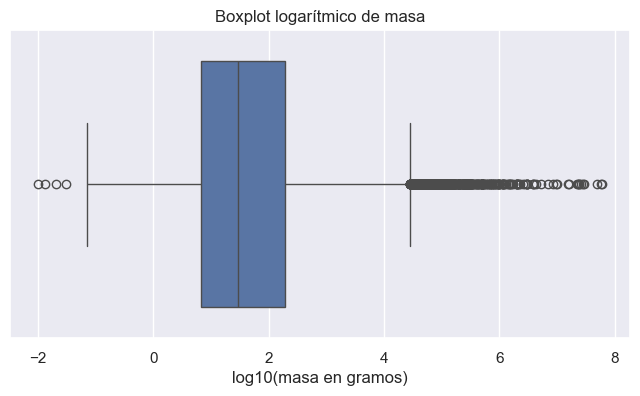

In [202]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df_clean['mass_log10'])
plt.title('Boxplot logarítmico de masa')
plt.xlabel('log10(masa en gramos)')
plt.savefig("../images/mass_log10_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()



## 📦 Boxplot logarítmico de la masa de los meteoritos

Este boxplot representa la distribución de la masa transformada a escala logarítmica (`mass_log10`).  
Es una visualización clave para entender la **presencia de outliers extremos** en la variable original `mass (g)`.

### ✔️ ¿Qué observamos?

- La mayor parte de los meteoritos se concentra entre valores de `log10(masa)` **1 y 3**, es decir:
  - Entre **10 g** y **1.000 g**, aproximadamente.
- Existe una cantidad **muy elevada de outliers** hacia valores altos:
  - Meteoritos de cientos de kilos o incluso varios miles aparecen como puntos aislados a la derecha.
- También existen algunos valores atípicos a la izquierda, asociados a masas muy bajas (cercanas a cero, tras limpiar los valores inválidos).

### 🔍 Interpretación técnica

- La masa de los meteoritos presenta una **distribución altamente sesgada positiva**.
- El uso de escala logarítmica permite:
  - Normalizar parcialmente la distribución.
  - Reducir el impacto de valores extremos.
  - Visualizar mejor el rango central de la masa.
- Aun así, los outliers persisten, lo que indica que la variable tiene una naturaleza intrínsecamente dispersa.

### 🧠 Conclusión

La variable `mass (g)` presenta una variabilidad extrema típica de fenómenos naturales.  
La transformación logarítmica es adecuada para análisis posteriores, ya que mejora la interpretación sin eliminar información relevante.

---



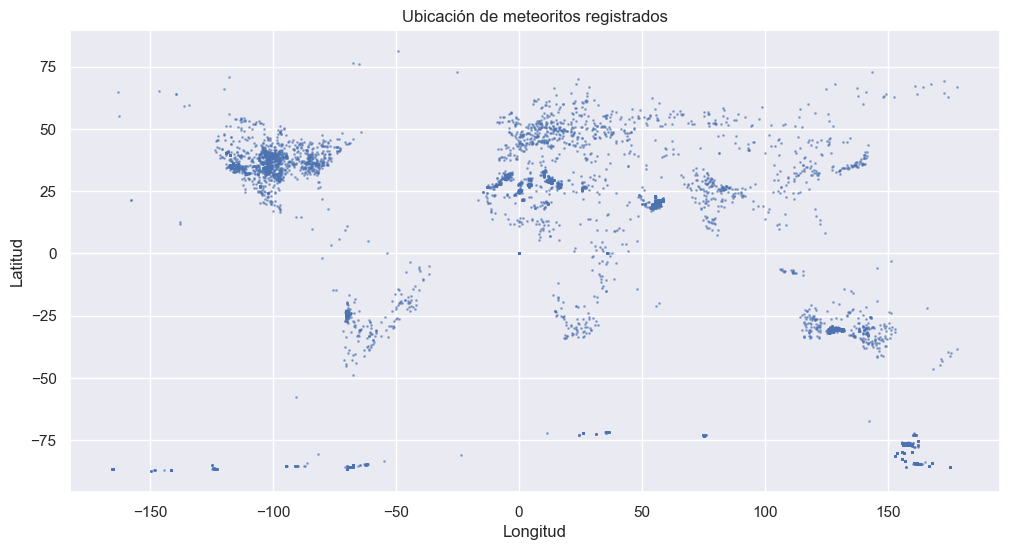

In [203]:
plt.figure(figsize=(12,6))
plt.scatter(df_clean['reclong'], df_clean['reclat'], s=1, alpha=0.5)
plt.title('Ubicación de meteoritos registrados')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.savefig("../images/meteorite_locations.png", dpi=300, bbox_inches='tight')
plt.show()



## 🗺️ Distribución geográfica de los meteoritos registrados

En esta visualización se muestran las coordenadas geográficas de cada meteorito del dataset ya limpio.  
Cada punto representa una entrada válida de `reclat` (latitud) y `reclong` (longitud).

### ✔️ ¿Qué patrones se observan?

- **Alta concentración en EEUU, Europa y el norte de África**  
  Esto no significa necesariamente que caigan más meteoritos allí, sino que:
  - Hay más población.
  - Hay más instituciones científicas.
  - Hay más sistemas de observación y registro.

- **Zonas muy vacías** como:
  - Amazonia  
  - Grandes desiertos remotos  
  - Siberia  
  - Oceanía interior  
  - Áreas polares  
  Estas zonas tienen poca presencia humana, por lo que muchos impactos quedan sin registrar.

- **El patrón global coincide perfectamente con el mapa político del mundo**, lo que confirma que:
  > *El dataset refleja más la actividad humana de registro que la distribución real de caídas.*

### 🔍 Interpretación técnica

- No se observan agrupaciones artificiales tras la limpieza de coordenadas.  
- Todas las ubicaciones muestran valores válidos dentro de sus rangos:
  - Latitud ∈ [-90, 90]  
  - Longitud ∈ [-180, 180]
- La dispersión confirma que la columna `GeoLocation` estaba correctamente generada a partir de `reclat` y `reclong`.

### 🧠 Conclusión geográfica

El análisis espacial revela un sesgo de registro altamente dependiente de la densidad poblacional.  
Es decir, el dataset refleja dónde *se buscan y se registran* meteoritos, no necesariamente dónde *caen*.



---



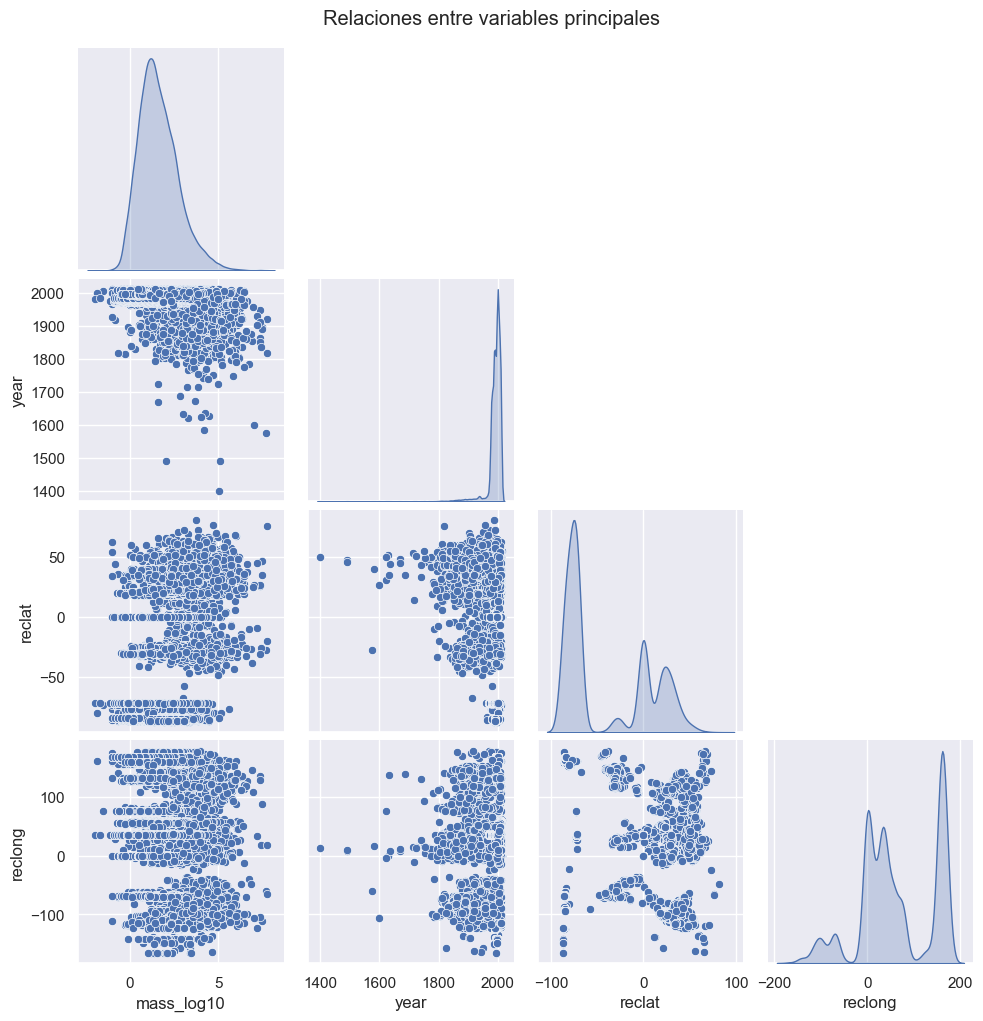

In [204]:
import seaborn as sns

cols = ['mass_log10', 'year', 'reclat', 'reclong']
sns.pairplot(df_clean[cols], corner=True, diag_kind='kde')
plt.suptitle('Relaciones entre variables principales', y=1.02)
plt.savefig('../images/pairplot_relaciones.png', dpi=300, bbox_inches='tight')
plt.show()


# 📌 Conclusiones del Análisis Exploratorio (EDA)

Tras realizar el EDA completo del dataset de **Meteorite Landings (NASA)** se pueden destacar los siguientes puntos clave:

---

## 🧹 1. Calidad y limpieza de los datos
- El dataset contiene **45.716 registros** originales.
- Se identificaron valores inválidos en:
  - **Año (`year`)** → valores imposibles (860, 2101).  
  - **Coordenadas (`reclat`, `reclong`)** → entradas fuera de rango geográfico ±90 / ±180.
  - **Masa (`mass (g)`)** → valores negativos o cero.
- Tras la limpieza, el dataset queda en **38.094 registros totalmente válidos**.
- La variable transformada `mass_log10` permite analizar correctamente distribuciones muy sesgadas.

---

## 📊 2. Principales hallazgos

### 🔸 **Distribución de masa**
- La masa está extremadamente sesgada hacia valores muy bajos.
- La escala logarítmica revela una forma mucho más informativa.
- Existen numerosos outliers de meteoritos de mucha masa.

### 🔸 **Categoría “Fall”**
- El 97% de los meteoritos son **Found**, no **Fell**, indicando:
  > La mayoría son hallados mucho tiempo después, no observados durante la caída.

### 🔸 **Clases meteoríticas (recclass)**
- Las clases más frecuentes son: **L6, H6, L5, H5**.  
- Refuerza que muchos meteoritos pertenecen a condritas ordinarias.

### 🔸 **Distribución temporal**
- El número de registros crece drásticamente a partir del siglo XX.  
- No es que caigan más meteoritos, sino:
  > Aumenta la capacidad de descubrimiento, documentación y archivo.

### 🔸 **Distribución geográfica**
- Los meteoritos se registran mayoritariamente en:
  - EEUU  
  - Europa  
  - Norte de África  
- Áreas casi vacías:
  - Amazonia  
  - Siberia  
  - Interior de Australia  
  - Desiertos remotos  
- Conclusión inequívoca:
  > El dataset refleja la **presencia humana**, no la distribución real de los impactos.

---

## 🧠 3. Conclusión general del EDA

Este EDA demuestra que:
- El dataset es **fiable pero está sesgado por factores humanos**.
- Es útil para analizar características de meteoritos, pero no para estudiar la distribución real de caídas.
- La limpieza realizada deja el dataset en un estado óptimo para futuros análisis o modelos.

---

## 🚀 4. Siguientes pasos (posibles mejoras)
- Crear variables geográficas como *continente* o *tipo de zona* (urbana/rural).
- Aplicar clustering geográfico.
- Estudiar correlaciones entre masa, clase y tipo de caída.
- Crear un modelo de clasificación por `recclass`.

